26 Oct 2025

#### Preliminaries

In [ ]:
#basic_operations
import os
import math
import pickle

#exploratory_data_analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

#data_generation 
from scipy.interpolate import splprep, splev

#deep_learning
import torch
import torch.nn as nn
from complexPyTorch.complexLayers import ComplexLinear, ComplexReLU
from torch.utils.data import TensorDataset, DataLoader, random_split

#gpu_usage
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

#random_seed
torch.manual_seed(42)
np.random.seed(42)

# Constants
epsilon = 1e-10

In [2]:
# Check if CUDA is available
print("Is CUDA available?", torch.cuda.is_available())

# Total number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# List all GPU names
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Is CUDA available? True
Number of GPUs available: 8
GPU 0: NVIDIA H100 80GB HBM3
GPU 1: NVIDIA H100 80GB HBM3
GPU 2: NVIDIA H100 80GB HBM3
GPU 3: NVIDIA H100 80GB HBM3
GPU 4: NVIDIA H100 80GB HBM3
GPU 5: NVIDIA H100 80GB HBM3
GPU 6: NVIDIA H100 80GB HBM3
GPU 7: NVIDIA H100 80GB HBM3


#### Trajectory Generation

In [20]:
# Environment Parameters
epsilon = 1e-10
seed = 42


grid_min, grid_max = 0, 1
step_size = 0.1 # epsilon # distance after which angle changes.
total_time = 10
lookahead = 2
velocity = np.random.uniform(1, 5)
total_distance = velocity * total_time
num_steps = np.floor(total_distance / step_size)
rng = np.random.default_rng()

#x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
#head_dir_initial = math.radians(30)
#print(x_initial, y_initial)

tier_1 = np.arange(-30, 30, 1)
tier_2 = list(range(-60, -30)) + list(range(30, 60))
tier_3 = list(range(-90, -60)) + list(range(60, 90))
num_tries = 10


In [21]:
def get_future_pos(x_current, y_current, head_dir_current):
  x_future = x_current + lookahead * step_size * math.cos(head_dir_current)
  y_future = y_current + lookahead * step_size * math.sin(head_dir_current)
  return x_future, y_future

In [22]:
# Tiered search (random within tiers)
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def choose_head_dir(x_current, y_current, head_dir_current):
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_1)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning slightly")
      return x_future, y_future, head_dir_next

  for _ in range(num_tries):  
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_2)))    
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning diagonally")
      return x_future, y_future, head_dir_next
  
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_3)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min <= x_future <= grid_max and grid_min < y_future < grid_max:
      #print("Turning almost orthagonally")
      return x_future, y_future, head_dir_next
    
  head_dir_next = wrap_angle(head_dir_current + math.radians(180))
  x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
  #print("Taking a U-turn")
  return x_future, y_future, head_dir_next

In [23]:
# Trajectory generation

def generate_trajectory(velocity):
    x_sharp = []
    y_sharp = []
    head_dir = []
    x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
    initial_positions = (x_initial, y_initial)
    head_dir_initial = math.radians(0)
    distance = velocity * total_time
    num_steps = np.floor(distance / step_size)

    for i in range(int(num_steps)):
        if i == 0:
            head_dir_current = head_dir_initial
            x_current, y_current = x_initial, y_initial
            x_sharp.append(x_current)
            y_sharp.append(y_current)
            head_dir.append(head_dir_current)
        
        x_future, y_future, head_dir_next = choose_head_dir(x_current, y_current, head_dir_current)
        x_next = x_current + step_size * math.cos(head_dir_next)
        y_next = y_current + step_size * math.sin(head_dir_next)
        
        head_dir_current = head_dir_next
        x_current, y_current = x_next, y_next

        x_sharp.append(x_current)
        y_sharp.append(y_current)
        head_dir.append(head_dir_current)


    x_sharp = np.array(x_sharp)
    y_sharp = np.array(y_sharp)
    head_dir = np.array(head_dir)
    initial_positions = np.array(initial_positions)
    #print(X.shape, Y.shape, HD.shape, initial_positions.shape)    
    return initial_positions, x_sharp, y_sharp    


In [24]:
# Using Spline function
def generate_smooth_trajectory(velocity):

    initial_positions, x_sharp, y_sharp = generate_trajectory(velocity)
    # s = smoothing factor, larger = smoother
    tck, u = splprep([x_sharp, y_sharp], s=0)
    u_new = np.linspace(0, 1, 1000)  # denser sampling
    x_smooth, y_smooth = splev(u_new, tck)
    return initial_positions, x_smooth, y_smooth

In [25]:
def compute_head_dir_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)-1):
        dx = x_smooth[i+1] - x_smooth[i]
        dy = y_smooth[i+1] - y_smooth[i]
        #heading_angle = math.atan2(dy, dx)
        norm = np.sqrt(dx**2 + dy**2) + 1e-8
        cos_theta = dx / norm
        sin_theta = dy / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    cos_thetas.append(cos_thetas[-1])  # Repeat last vector to maintain length
    sin_thetas.append(sin_thetas[-1])  # Repeat last vector to maintain length
    return cos_thetas, sin_thetas

def compute_head_dir_angles(x_smooth, y_smooth):
    head_dir_angles = []
    for i in range(len(x_smooth)-1):
        dx = x_smooth[i+1] - x_smooth[i]
        dy = y_smooth[i+1] - y_smooth[i]
        heading_angle = math.atan2(dy, dx)
        head_dir_angles.append(heading_angle)
    head_dir_angles.append(head_dir_angles[-1])  # Repeat last angle to maintain length
    return head_dir_angles

In [26]:
# Clockwise from bottom-left corner

def build_wall_landmarks(n_per_wall = 4):
    pos = np.linspace(0.2, 0.8, n_per_wall)
    landmarks = []

    landmarks.append((0.0, 0.0))
    for y in pos: landmarks.append((0.0, y))
    landmarks.append((0.0, 1.0))
    for x in pos: landmarks.append((x, 1.0))
    landmarks.append((1.0, 1.0))
    for y in reversed(pos): landmarks.append((1.0, y))
    landmarks.append((1.0, 0.0))
    for x in reversed(pos): landmarks.append((x, 0.0))
    
    return np.array(landmarks)


In [27]:
def generate_visual_cue(x_smooth, y_smooth, landmarks, fov = np.pi):
    cos_thetas, sin_thetas = compute_head_dir_vectors(x_smooth, y_smooth)
    L = len(landmarks)
    T = len(x_smooth)
    visual_cue = np.zeros((T, L), dtype=np.int8)
    fov_half_cos = math.cos(fov / 2)  
    for t in range(T):
        xt, yt = x_smooth[t], y_smooth[t]
        current_head_dir_vector = np.array([cos_thetas[t], sin_thetas[t]])

        for l in range(L):
            xl, yl = landmarks[l]
            r = np.array([xl - xt, yl - yt])
            distance = np.linalg.norm(r) + epsilon
            dot = np.dot(current_head_dir_vector, r)
            cos_angle = dot / distance

            if dot > 0 and cos_angle >= fov_half_cos:
                visual_cue[t, l] = 1
    
    return visual_cue

In [28]:
# Limb oscillations with curvature

#Parameters

dt = 0.01 # time step
time_series = np.arange(0, total_time, dt)
total_time_steps = len(time_series)

am = 0.1 # stride length
L = 0.05 # length of limb
phi = math.pi #phase difference between contralateral limbs
d = 0.05 # spacing between limb pairs

theta_m = am / (4 * L) # max angle of limb movement
limb_osc_freq = rng.uniform(1, 5) # frequency of limb oscillation
omega = 2 * math.pi * limb_osc_freq # angular frequency

def curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    return (dx * ddy - dy * ddx) / ((dx**2 + dy**2)**1.5 + 1e-8)
    # To avoid division by zero

def limb_oscillations_with_curvature(t, am, L, omega, phi, d, x, y):
    theta_m = am / (4 * L)
    k = curvature(x, y)

    UFL = theta_m * (1 + k*d) * np.sin(omega*t)
    UFR = theta_m * (1 - k*d) * np.sin(omega*t + phi)
    UHR = theta_m * (1 - k*d) * np.sin(omega*t)
    UHL = theta_m * (1 + k*d) * np.sin(omega*t + phi)

    return UFL, UFR, UHR, UHL, k

In [29]:
# Generate 100 trajectories and corresponding limb oscillations

def generate_data(num_trajectories):
    x_smooth_all, y_smooth_all = [], []
    limb_data_all = []
    angles_all = []
    #initial_positions_all = []
    visual_cues_all = []
    cos_thetas_all, sin_thetas_all = [], []

    for trajectory in range(num_trajectories):
        limb_osc_freq = np.random.uniform(1, 5)
        velocity = am * limb_osc_freq
        omega = 2 * math.pi * limb_osc_freq #angular frequency
        
        initial_positions, x_smooth, y_smooth = generate_smooth_trajectory(velocity)
        limb_data = limb_oscillations_with_curvature(time_series, am, L, omega, phi, d, x_smooth, y_smooth)
        cos_thetas, sin_thetas = compute_head_dir_vectors(x_smooth, y_smooth)
        angles = compute_head_dir_angles(x_smooth, y_smooth)
        visual_cue_data = generate_visual_cue(x_smooth, y_smooth, build_wall_landmarks())
        
        #initial_positions_all.append(initial_positions)
        
        x_smooth_all.append(x_smooth)
        y_smooth_all.append(y_smooth)
        cos_thetas_all.append(cos_thetas)
        sin_thetas_all.append(sin_thetas)
        visual_cues_all.append(visual_cue_data)
        limb_data_all.append(limb_data)
        angles_all.append(angles)


    return x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, visual_cues_all, limb_data_all
    print("Generated", num_trajectories, "trajectories with corresponding limb oscillations.")

x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, visual_cues_all, limb_data_all = generate_data(100)


In [30]:
visual_cues_all = np.array(visual_cues_all)
x_smooth_all = np.array(x_smooth_all)
y_smooth_all = np.array(y_smooth_all)
limb_data_all = np.array(limb_data_all)
cos_thetas_all = np.array(cos_thetas_all)
sin_thetas_all = np.array(sin_thetas_all)

print(visual_cues_all.shape, x_smooth_all.shape, y_smooth_all.shape, cos_thetas_all.shape, sin_thetas_all.shape, limb_data_all.shape)

(100, 1000, 20) (100, 1000) (100, 1000) (100, 1000) (100, 1000) (100, 5, 1000)


In [31]:
traj_data = np.stack((x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all), axis=-1)
traj_data = np.array(traj_data)
print(traj_data.shape)

limb_data_with_curvature = limb_data_all.transpose(0, 2, 1)  # (num_trajectories, time_steps, 4 limbs + curvature)
#print(limb_data_with_curvature.shape) # (100, 1000, 5)
limb_data = limb_data_with_curvature[:, :, :4]
#print(limb_data.shape) #(100, 1000, 4)

#initial_positions_all_expanded = np.repeat(initial_positions_all[:, :, np.newaxis], 1000, axis=2)
#print(initial_positions_all_expanded.shape)  # (100, 2, 1000)
#initial_positions_transpose = initial_positions_all_expanded.transpose(0, 2, 1)
#print(initial_positions_transpose.shape)  # (100, 1000, 2)

limb_data_visual = np.concatenate((limb_data, visual_cues_all), axis=2)
print(limb_data_visual.shape) # (100, 1000, 6)

(100, 1000, 4)
(100, 1000, 24)


In [32]:
X = limb_data_visual
Y = {'pos': traj_data[:, :, :2], 'hd': traj_data[:, :, 2:]}

print(X.shape, len(Y), Y['pos'].shape, Y['hd'].shape)

(100, 1000, 24) 2 (100, 1000, 2) (100, 1000, 2)


In [ ]:
data_path = '0_trajectory_data/'
X_data_file = '27_10_input_data.pkl'
Y_data_file = '27_10_output_data.pkl'

with open(f'{data_path}{X_data_file}', 'wb') as f:
    pickle.dump(X, f)

with open(f'{data_path}{Y_data_file}', 'wb') as f:
    pickle.dump(Y, f)
    

#### Loading Saved Trajectories

In [3]:
data_path = '0_trajectory_data/'
X_data_file = '27_10_input_data.pkl'
Y_data_file = '27_10_output_data.pkl'

with open(f'{data_path}{X_data_file}', 'rb') as f:
    X_loaded = pickle.load(f)

with open(f'{data_path}{Y_data_file}', 'rb') as f:
    Y_loaded = pickle.load(f)

X = X_loaded
Y = Y_loaded

print(X.shape, Y.keys(), Y['pos'].shape, Y['hd'].shape)

(100, 1000, 24) dict_keys(['pos', 'hd']) (100, 1000, 2) (100, 1000, 2)


In [4]:
time_series_size = X.shape[1]
print(time_series_size)

time_series = np.arange(0, time_series_size)
print(time_series.shape)

total_time_steps = len(time_series)

1000
(1000,)


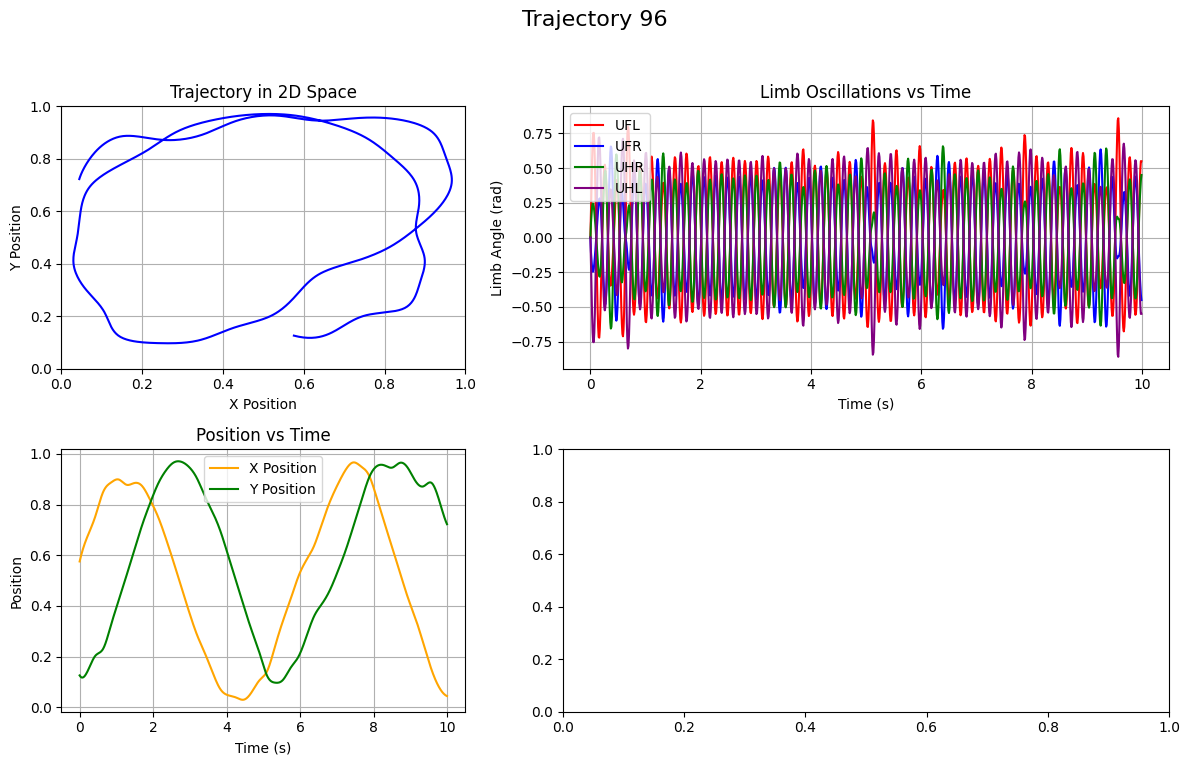

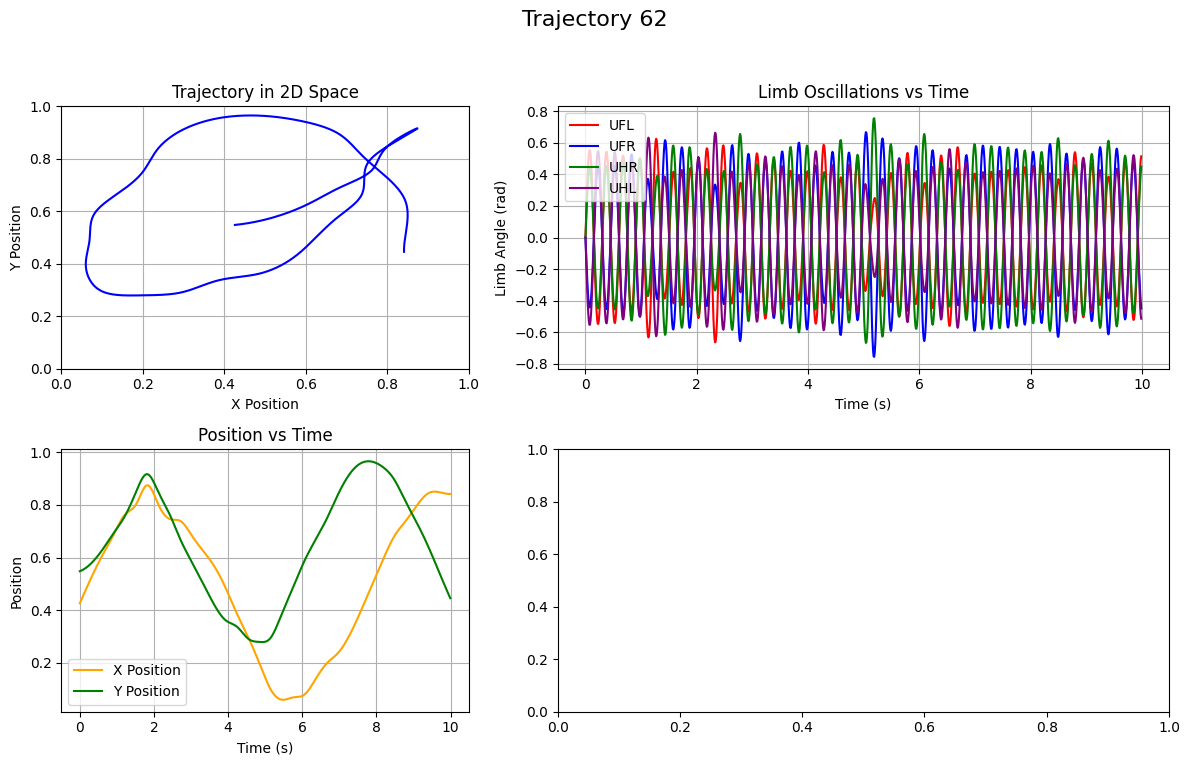

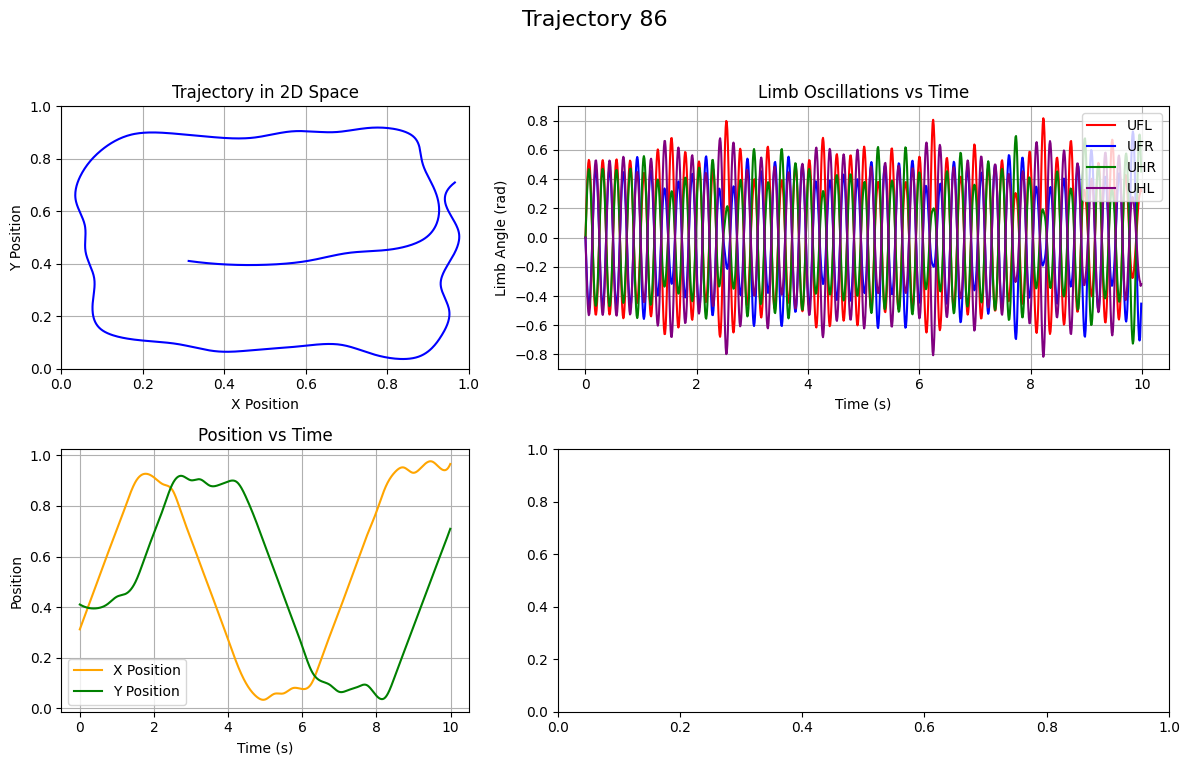

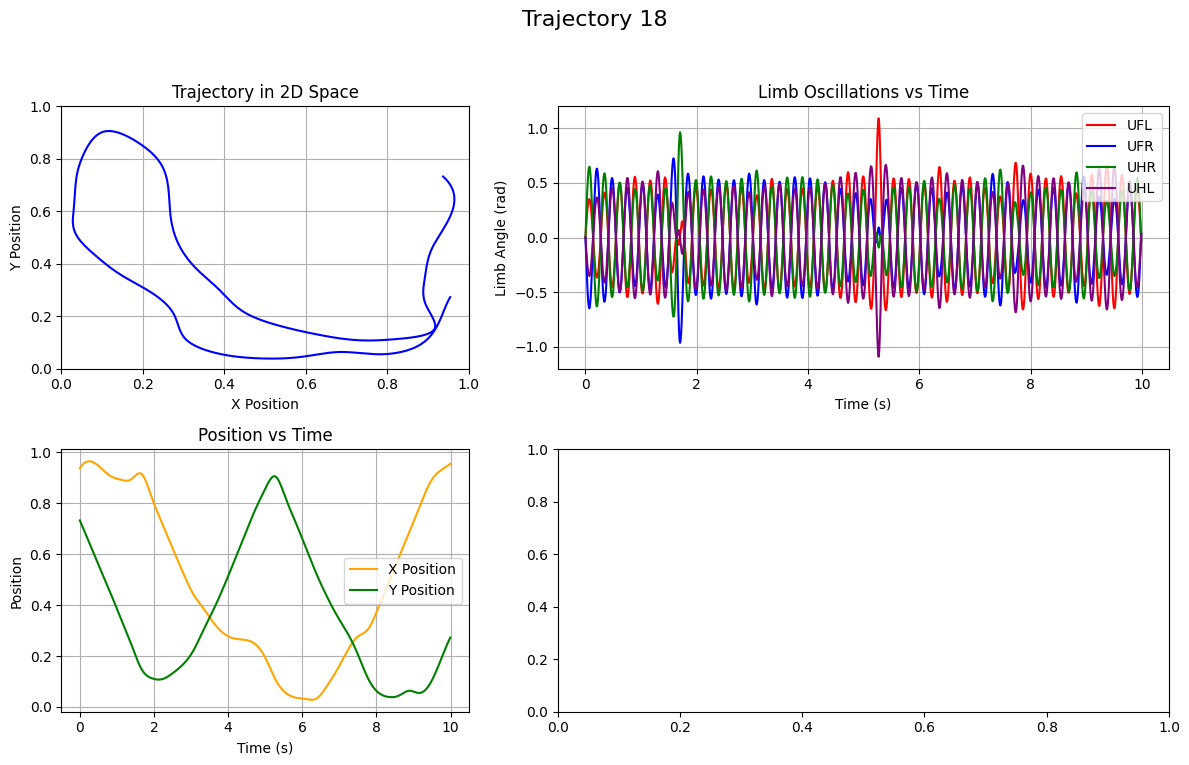

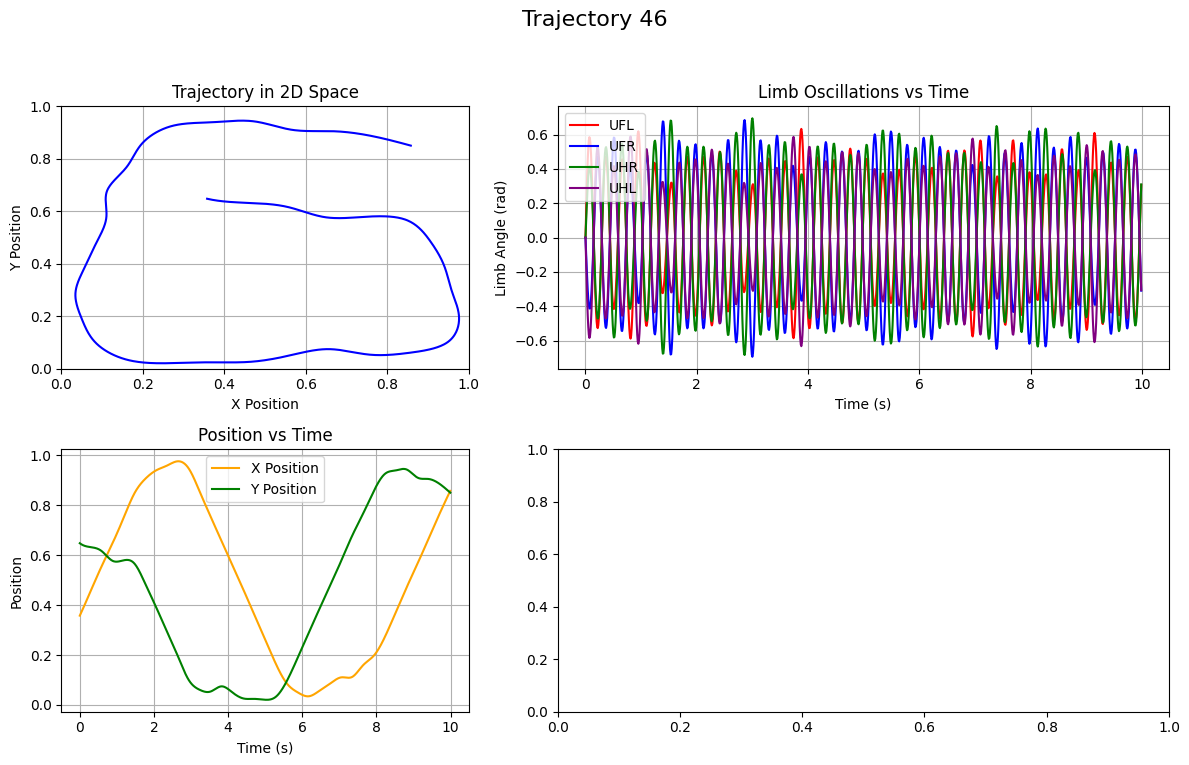

"\n    #Plotting k values\n    ax_bottom_right = axes[1, 1]\n\n    ax_bottom_right.plot(t, k_traj[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)\n    #ax_bottom_right.set_ylim(-30, 30)\n    ax_bottom_right.legend()\n    #ax_bottom_right.set_ylabel('Curvature (k)')\n\n"

In [33]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    traj_data = Y['pos'][traj_index]
    x_traj = traj_data[:, 0]
    y_traj = traj_data[:, 1]
    limb_data_traj = X[traj_index, :, :4]
    #limb_data_traj = limb_data_with_curvature[traj_index]
    UFL_traj, UFR_traj, UHR_traj, UHL_traj = limb_data_traj.T

    # Time vector
    t = time_series[:len(x_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(x_traj, y_traj, color='blue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, x_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, y_traj, label='Y Position', color='green')
    #axes[1, 0].plot(t, head_direction_traj[:len(t)], label='Head Direction', color='purple', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL_traj[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR_traj[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR_traj[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL_traj[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

'''
    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k_traj[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    #ax_bottom_right.set_ylim(-30, 30)
    ax_bottom_right.legend()
    #ax_bottom_right.set_ylabel('Curvature (k)')

'''
    #ax_k.legend(loc='upper right')

    

In [34]:
#Hopf Oscillator

def real_cal(r, phi):
    return r * torch.cos(phi)

def imag_cal(r, phi):
    return r * torch.sin(phi)


def oscillator_loop(X_r, X_i, omegas, num_steps, dt=0.01, input_scaler=10.0):
    
    """
    X_r, X_i: real and imaginary parts of input signal [batch, time, units]
    omegas: angular frequencies of oscillators [1, units]
    num_steps: number of time steps
    """

    batch_size, _, units = X_r.shape
    

    # amplitude and phase initialisation
    r_t = torch.ones((batch_size, units), device=X_r.device)
    phis = torch.zeros((batch_size, units), device=X_r.device)

    #r_t = 0.9 + 0.2 * torch.rand((batch_size, units), device=X_r.device)
    #phis = (2 * math.pi) * torch.rand((batch_size, units), device=X_r.device) - math.pi

    r_list, phi_list = [], []

    for t in range(num_steps):
        # input at current time step
        input_r = input_scaler * X_r[:, t, :] * torch.cos(phis)
        input_phi = input_scaler * X_i[:, t, :] * torch.sin(phis)

        # Hopf oscillator update equations
        r_t = r_t + ((1 - r_t**2) * r_t + input_r) * dt
        phis = phis + (omegas - input_phi) * dt

        r_list.append(r_t.unsqueeze(1))   # keep time dimension
        phi_list.append(phis.unsqueeze(1))

    # Stack time axis -> shape [batch, time, units]
    r_arr = torch.cat(r_list, dim=1)
    phi_arr = torch.cat(phi_list, dim=1)
    return r_arr, phi_arr



class Hopf(nn.Module):
    def __init__(self, units, num_steps, min_f=0.1, max_f=10.1):
        super(Hopf, self).__init__()
        self.units = units
        self.num_steps = num_steps

        # Frequencies equally spaced between min_f and max_f
        omegas = torch.linspace(min_f, max_f, units) * (2 * math.pi)
        self.register_buffer('omegas', omegas.unsqueeze(0))  # [1, units]

    def forward(self, z_complex):
        """
        z_complex: complex input tensor [batch, time, units]
        """
        X_r = z_complex.real
        X_i = z_complex.imag

        r, phi = oscillator_loop(X_r, X_i, self.omegas, self.num_steps)

        z_real = real_cal(r, phi)
        z_imag = imag_cal(r, phi)
        return torch.complex(z_real, z_imag)


In [35]:

class DONN(nn.Module):
    def __init__(self, units, duration):
        super(DONN, self).__init__()

        # -----------------------------
        # Complex Dense + Hopf layers
        # -----------------------------
        self.d1 = nn.Sequential(
            ComplexLinear(X.shape[-1], units),
            ComplexReLU()
        )
        self.osc1 = Hopf(units, num_steps=duration, min_f=1, max_f=5)

        self.d2 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc2 = Hopf(units, num_steps=duration, min_f=4, max_f=8)

        self.d3 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc3 = Hopf(units, num_steps=duration, min_f=8, max_f=10)

        self.d4 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )

        # -----------------------------
        # Real-valued output heads
        # -----------------------------
        self.pos_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (x, y)
            nn.Sigmoid()
        )

        self.hd_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (cosθ, sinθ)
            nn.Tanh()
        )

        self.z1 = None
        self.z2 = None
        self.z3 = None
        

    def forward(self, X):
        """
        X: [batch, time, units] real input signal
        """

        # Convert to complex
        X_c = torch.complex(X, torch.zeros_like(X))

        # Sequential complex transformations + Hopf oscillations
        d1 = self.d1(X_c)
        z1 = self.osc1(d1)
        self.z1 = z1

        d2 = self.d2(z1)
        z2 = self.osc2(d2)
        self.z2 = z2

        d3 = self.d3(z2)
        z3 = self.osc3(d3)
        self.z3 = z3

        d4 = self.d4(z3)
        
        # Concatenate real + imag for output layers
        d4_concat = torch.cat([d4.real, d4.imag], dim=-1)

        # Position output (sigmoid) → (x, y)
        pos_out = self.pos_out(d4_concat)

        # Head direction output (tanh) → (cosθ, sinθ)
        hd_out = self.hd_out(d4_concat)
        hd_norm = hd_out / (torch.norm(hd_out, dim=-1, keepdim=True) + 1e-8)
        
    
        return {"pos": pos_out, "hd": hd_norm}
        


In [36]:
# Slowly increase beta 0.2, 0.3...

def custom_hd_loss(hd_pred, hd_true, alpha=0.5, beta=0.5):
    """
    Custom head-direction loss combining cosine similarity + circular penalty.
    """
    # Normalize both true and predicted vectors
    hd_true = hd_true / (torch.norm(hd_true, dim=-1, keepdim=True) + 1e-8)
    hd_pred = hd_pred / (torch.norm(hd_pred, dim=-1, keepdim=True) + 1e-8)

    # Cosine similarity loss
    cos_sim = torch.sum(hd_true * hd_pred, dim=-1)
    cos_sim_loss = 1.0 - torch.mean(cos_sim)

    # Circle penalty: (cos^2 + sin^2 - 1)^2
    circle_loss = torch.mean((torch.sum(hd_pred ** 2, dim=-1) - 1.0) ** 2)

    return alpha * cos_sim_loss + beta * circle_loss
    #return cos_sim_loss


In [37]:

# Hyperparameters
units = 100
learning_rate = 0.001
batch_size = 20
#epochs = 300

duration = total_time_steps  # same as in TF version

# Initialize model
model = DONN(units=units, duration=duration)

# ========================GPU Usage========================
# Template:
'''
Instantiate the model
Define primary device
Move model to primary device
Wrap things like DataParallel or DDP if needed
'''

# To use any GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#To use a specific GPU
#device = torch.device("cuda:1")
#model.to(device)

# To use all GPUs in parallel
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model = nn.DataParallel(model)

# To use a specific SET of GPUs
# device_ids = [1, 2, 3]
# device = torch.device(f'cuda:{device_ids[0]}')
# model = model.to(f'cuda:{device_ids[0]}')
# model = nn.DataParallel(model, device_ids=device_ids)

# Distributed Data Parallel (DDP)
# For large processes
# Code modularization needed for this

#Print the GPUs being used
print("Model is running on:", next(model.parameters()).device)

# ========================GPU Usage========================

# Optimizer and loss functions
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()


Model is running on: cuda:0


In [38]:
# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_pos_tensor = torch.tensor(Y["pos"], dtype=torch.float32)
Y_hd_tensor = torch.tensor(Y["hd"], dtype=torch.float32)

# Combine into one dataset
dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_hd_tensor)

# 80-20 train-validation split
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [39]:
def training_loop(model, optimizer, train_loader, val_loader, start_epoch, end_epoch, pos_loss_weight, hd_loss_weight, save_every=100, save_path="1_network_data/checkpoints/2d_checkpoint"):
    train_losses, val_losses = [], []
    
    for epoch in range(start_epoch, end_epoch):
        model.train()
        total_loss = 0.0
        
        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{end_epoch}", leave=False)
        
        for X_batch, Y_pos_batch, Y_hd_batch in batch_bar:
            X_batch, Y_pos_batch, Y_hd_batch = X_batch.to(device), Y_pos_batch.to(device), Y_hd_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            pos_pred = outputs["pos"]
            hd_pred = outputs["hd"]

            # Compute combined loss
            loss_pos = mse_loss(pos_pred, Y_pos_batch)
            loss_hd = mse_loss(hd_pred, Y_hd_batch)
            #loss_hd = custom_hd_loss(hd_pred, Y_hd_batch)
            #loss_hd = mse_loss(hd_pred, Y_hd_batch)
            loss = pos_loss_weight * loss_pos + hd_loss_weight * loss_hd
            

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for X_val, Y_pos_val, Y_hd_val in val_loader:
                X_val, Y_pos_val, Y_hd_val = X_val.to(device), Y_pos_val.to(device), Y_hd_val.to(device)
                outputs = model(X_val)
                pos_pred = outputs["pos"]
                hd_pred = outputs["hd"]
                val_loss += (mse_loss(pos_pred, Y_pos_val) + custom_hd_loss(hd_pred, Y_hd_val)).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f"Epoch [{epoch+1}/{end_epoch}] | Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")

        if (epoch + 1) % save_every == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, f"{save_path}_epoch{epoch+1}.pth")
            tqdm.write(f"Saved checkpoint at epoch {epoch+1}")    

    return model, optimizer, end_epoch, train_losses, val_losses            

In [29]:
pos_loss_weight = 0.7
hd_loss_weight = 0.3

# Change the start and end epochs to resume training in the same session
start_epoch = 0
end_epoch = 300

model, optimizer, last_epoch, train_losses, val_losses = training_loop(
    model, optimizer, train_loader, val_loader,
    start_epoch=start_epoch, end_epoch=end_epoch,
    pos_loss_weight=pos_loss_weight, hd_loss_weight=hd_loss_weight)

Epoch [1/300] | Train Loss: 0.365794 | Val Loss: 0.555176


Epoch [2/300] | Train Loss: 0.336374 | Val Loss: 0.531638


Epoch [3/300] | Train Loss: 0.317922 | Val Loss: 0.520104


Epoch [4/300] | Train Loss: 0.301582 | Val Loss: 0.499205


Epoch [5/300] | Train Loss: 0.287219 | Val Loss: 0.487321


Epoch [6/300] | Train Loss: 0.275097 | Val Loss: 0.471784


Epoch [7/300] | Train Loss: 0.265550 | Val Loss: 0.467968


Epoch [8/300] | Train Loss: 0.254116 | Val Loss: 0.457378


Epoch [9/300] | Train Loss: 0.241793 | Val Loss: 0.448582


Epoch [10/300] | Train Loss: 0.230019 | Val Loss: 0.436811


Epoch [11/300] | Train Loss: 0.220103 | Val Loss: 0.424415


Epoch [12/300] | Train Loss: 0.209623 | Val Loss: 0.413624


Epoch [13/300] | Train Loss: 0.198722 | Val Loss: 0.407983


Epoch [14/300] | Train Loss: 0.191264 | Val Loss: 0.398703


Epoch [15/300] | Train Loss: 0.181788 | Val Loss: 0.390944


Epoch [16/300] | Train Loss: 0.173889 | Val Loss: 0.394039


Epoch [17/300] | Train Loss: 0.167017 | Val Loss: 0.382545


Epoch [18/300] | Train Loss: 0.161116 | Val Loss: 0.378278


Epoch [19/300] | Train Loss: 0.154085 | Val Loss: 0.372257


Epoch [20/300] | Train Loss: 0.148240 | Val Loss: 0.378760


Epoch [21/300] | Train Loss: 0.142567 | Val Loss: 0.367076


Epoch [22/300] | Train Loss: 0.138724 | Val Loss: 0.369797


Epoch [23/300] | Train Loss: 0.132682 | Val Loss: 0.362644


Epoch [24/300] | Train Loss: 0.128400 | Val Loss: 0.366205


Epoch [25/300] | Train Loss: 0.123965 | Val Loss: 0.352714


Epoch [26/300] | Train Loss: 0.117621 | Val Loss: 0.351680


Epoch [27/300] | Train Loss: 0.112573 | Val Loss: 0.344656


Epoch [28/300] | Train Loss: 0.107315 | Val Loss: 0.348034


Epoch [29/300] | Train Loss: 0.103510 | Val Loss: 0.343839


Epoch [30/300] | Train Loss: 0.098513 | Val Loss: 0.347115


Epoch [31/300] | Train Loss: 0.095042 | Val Loss: 0.361059


Epoch [32/300] | Train Loss: 0.095392 | Val Loss: 0.342189


Epoch [33/300] | Train Loss: 0.089734 | Val Loss: 0.333518


Epoch [34/300] | Train Loss: 0.085936 | Val Loss: 0.337525


Epoch [35/300] | Train Loss: 0.083039 | Val Loss: 0.329999


Epoch [36/300] | Train Loss: 0.080702 | Val Loss: 0.332628


Epoch [37/300] | Train Loss: 0.079400 | Val Loss: 0.330852


Epoch [38/300] | Train Loss: 0.077628 | Val Loss: 0.326185


Epoch [39/300] | Train Loss: 0.077325 | Val Loss: 0.331655


Epoch [40/300] | Train Loss: 0.075935 | Val Loss: 0.323597


Epoch [41/300] | Train Loss: 0.073841 | Val Loss: 0.324802


Epoch [42/300] | Train Loss: 0.072924 | Val Loss: 0.325035


Epoch [43/300] | Train Loss: 0.072828 | Val Loss: 0.327358


Epoch [44/300] | Train Loss: 0.070431 | Val Loss: 0.328794


Epoch [45/300] | Train Loss: 0.069770 | Val Loss: 0.324197


Epoch [46/300] | Train Loss: 0.068677 | Val Loss: 0.332318


Epoch [47/300] | Train Loss: 0.066559 | Val Loss: 0.323113


Epoch [48/300] | Train Loss: 0.065873 | Val Loss: 0.316723


Epoch [49/300] | Train Loss: 0.064805 | Val Loss: 0.322430


Epoch [50/300] | Train Loss: 0.064025 | Val Loss: 0.330075


Epoch [51/300] | Train Loss: 0.062124 | Val Loss: 0.314996


Epoch [52/300] | Train Loss: 0.061399 | Val Loss: 0.319668


Epoch [53/300] | Train Loss: 0.059720 | Val Loss: 0.326618


Epoch [54/300] | Train Loss: 0.058725 | Val Loss: 0.315929


Epoch [55/300] | Train Loss: 0.057419 | Val Loss: 0.318727


Epoch [56/300] | Train Loss: 0.056658 | Val Loss: 0.324106


Epoch [57/300] | Train Loss: 0.057297 | Val Loss: 0.317935


Epoch [58/300] | Train Loss: 0.056812 | Val Loss: 0.324295


Epoch [59/300] | Train Loss: 0.056561 | Val Loss: 0.313831


Epoch [60/300] | Train Loss: 0.055326 | Val Loss: 0.316035


Epoch [61/300] | Train Loss: 0.053048 | Val Loss: 0.315028


Epoch [62/300] | Train Loss: 0.051865 | Val Loss: 0.318484


Epoch [63/300] | Train Loss: 0.050416 | Val Loss: 0.314075


Epoch [64/300] | Train Loss: 0.048970 | Val Loss: 0.306771


Epoch [65/300] | Train Loss: 0.047822 | Val Loss: 0.311662


Epoch [66/300] | Train Loss: 0.046978 | Val Loss: 0.307599


Epoch [67/300] | Train Loss: 0.045774 | Val Loss: 0.318329


Epoch [68/300] | Train Loss: 0.045520 | Val Loss: 0.312249


Epoch [69/300] | Train Loss: 0.043877 | Val Loss: 0.303799


Epoch [70/300] | Train Loss: 0.042909 | Val Loss: 0.313476


Epoch [71/300] | Train Loss: 0.042248 | Val Loss: 0.306916


Epoch [72/300] | Train Loss: 0.041242 | Val Loss: 0.303708


Epoch [73/300] | Train Loss: 0.040009 | Val Loss: 0.305764


Epoch [74/300] | Train Loss: 0.038763 | Val Loss: 0.297628


Epoch [75/300] | Train Loss: 0.038106 | Val Loss: 0.306929


Epoch [76/300] | Train Loss: 0.037670 | Val Loss: 0.306581


Epoch [77/300] | Train Loss: 0.036891 | Val Loss: 0.298709


Epoch [78/300] | Train Loss: 0.035817 | Val Loss: 0.298602


Epoch [79/300] | Train Loss: 0.034696 | Val Loss: 0.300438


Epoch [80/300] | Train Loss: 0.033657 | Val Loss: 0.296031


Epoch [81/300] | Train Loss: 0.032470 | Val Loss: 0.300767


Epoch [82/300] | Train Loss: 0.031848 | Val Loss: 0.296875


Epoch [83/300] | Train Loss: 0.031858 | Val Loss: 0.295851


Epoch [84/300] | Train Loss: 0.031960 | Val Loss: 0.297420


Epoch [85/300] | Train Loss: 0.031090 | Val Loss: 0.303824


Epoch [86/300] | Train Loss: 0.031217 | Val Loss: 0.300196


Epoch [87/300] | Train Loss: 0.030213 | Val Loss: 0.298864


Epoch [88/300] | Train Loss: 0.029301 | Val Loss: 0.294672


Epoch [89/300] | Train Loss: 0.028765 | Val Loss: 0.296507


Epoch [90/300] | Train Loss: 0.027876 | Val Loss: 0.298077


Epoch [91/300] | Train Loss: 0.027066 | Val Loss: 0.301663


Epoch [92/300] | Train Loss: 0.026306 | Val Loss: 0.293515


Epoch [93/300] | Train Loss: 0.026063 | Val Loss: 0.294369


Epoch [94/300] | Train Loss: 0.025597 | Val Loss: 0.293832


Epoch [95/300] | Train Loss: 0.025380 | Val Loss: 0.293557


Epoch [96/300] | Train Loss: 0.025022 | Val Loss: 0.298642


Epoch [97/300] | Train Loss: 0.024660 | Val Loss: 0.292733


Epoch [98/300] | Train Loss: 0.023835 | Val Loss: 0.291827


Epoch [99/300] | Train Loss: 0.023352 | Val Loss: 0.294417


Epoch [100/300] | Train Loss: 0.023202 | Val Loss: 0.293921
Saved checkpoint at epoch 100


Epoch [101/300] | Train Loss: 0.022772 | Val Loss: 0.288938


Epoch [102/300] | Train Loss: 0.022263 | Val Loss: 0.296229


Epoch [103/300] | Train Loss: 0.021971 | Val Loss: 0.293821


Epoch [104/300] | Train Loss: 0.021975 | Val Loss: 0.291810


Epoch [105/300] | Train Loss: 0.021773 | Val Loss: 0.292469


Epoch [106/300] | Train Loss: 0.022125 | Val Loss: 0.289544


Epoch [107/300] | Train Loss: 0.021492 | Val Loss: 0.291692


Epoch [108/300] | Train Loss: 0.020640 | Val Loss: 0.294475


Epoch [109/300] | Train Loss: 0.020354 | Val Loss: 0.288964


Epoch [110/300] | Train Loss: 0.019867 | Val Loss: 0.290678


Epoch [111/300] | Train Loss: 0.019624 | Val Loss: 0.292009


Epoch [112/300] | Train Loss: 0.019284 | Val Loss: 0.293862


Epoch [113/300] | Train Loss: 0.019140 | Val Loss: 0.292356


Epoch [114/300] | Train Loss: 0.019086 | Val Loss: 0.295701


Epoch [115/300] | Train Loss: 0.019268 | Val Loss: 0.291527


Epoch [116/300] | Train Loss: 0.018982 | Val Loss: 0.296859


Epoch [117/300] | Train Loss: 0.018776 | Val Loss: 0.288193


Epoch [118/300] | Train Loss: 0.019203 | Val Loss: 0.286143


Epoch [119/300] | Train Loss: 0.018948 | Val Loss: 0.294277


Epoch [120/300] | Train Loss: 0.019070 | Val Loss: 0.289742


Epoch [121/300] | Train Loss: 0.018497 | Val Loss: 0.294497


Epoch [122/300] | Train Loss: 0.019327 | Val Loss: 0.296926


Epoch [123/300] | Train Loss: 0.018872 | Val Loss: 0.292108


Epoch [124/300] | Train Loss: 0.018881 | Val Loss: 0.289170


Epoch [125/300] | Train Loss: 0.018415 | Val Loss: 0.293973


Epoch [126/300] | Train Loss: 0.018673 | Val Loss: 0.293120


Epoch [127/300] | Train Loss: 0.018096 | Val Loss: 0.297044


Epoch [128/300] | Train Loss: 0.017851 | Val Loss: 0.292358


Epoch [129/300] | Train Loss: 0.017188 | Val Loss: 0.291823


Epoch [130/300] | Train Loss: 0.016801 | Val Loss: 0.290448


Epoch [131/300] | Train Loss: 0.016758 | Val Loss: 0.297955


Epoch [132/300] | Train Loss: 0.016480 | Val Loss: 0.291710


Epoch [133/300] | Train Loss: 0.016340 | Val Loss: 0.290660


Epoch [134/300] | Train Loss: 0.016098 | Val Loss: 0.292813


Epoch [135/300] | Train Loss: 0.015994 | Val Loss: 0.295702


Epoch [136/300] | Train Loss: 0.015898 | Val Loss: 0.295991


Epoch [137/300] | Train Loss: 0.015790 | Val Loss: 0.293017


Epoch [138/300] | Train Loss: 0.015900 | Val Loss: 0.291605


Epoch [139/300] | Train Loss: 0.015562 | Val Loss: 0.293852


Epoch [140/300] | Train Loss: 0.015277 | Val Loss: 0.289833


Epoch [141/300] | Train Loss: 0.015813 | Val Loss: 0.292801


Epoch [142/300] | Train Loss: 0.015612 | Val Loss: 0.293162


Epoch [143/300] | Train Loss: 0.015044 | Val Loss: 0.292675


Epoch [144/300] | Train Loss: 0.014913 | Val Loss: 0.294634


Epoch [145/300] | Train Loss: 0.014875 | Val Loss: 0.298493


Epoch [146/300] | Train Loss: 0.015248 | Val Loss: 0.294245


Epoch [147/300] | Train Loss: 0.014954 | Val Loss: 0.292232


Epoch [148/300] | Train Loss: 0.014671 | Val Loss: 0.291557


Epoch [149/300] | Train Loss: 0.014244 | Val Loss: 0.296747


Epoch [150/300] | Train Loss: 0.014070 | Val Loss: 0.293317


Epoch [151/300] | Train Loss: 0.014012 | Val Loss: 0.292255


Epoch [152/300] | Train Loss: 0.013866 | Val Loss: 0.295015


Epoch [153/300] | Train Loss: 0.013864 | Val Loss: 0.291657


Epoch [154/300] | Train Loss: 0.013782 | Val Loss: 0.293419


Epoch [155/300] | Train Loss: 0.013734 | Val Loss: 0.292083


Epoch [156/300] | Train Loss: 0.013472 | Val Loss: 0.294192


Epoch [157/300] | Train Loss: 0.013569 | Val Loss: 0.292930


Epoch [158/300] | Train Loss: 0.013464 | Val Loss: 0.291285


Epoch [159/300] | Train Loss: 0.013225 | Val Loss: 0.292098


Epoch [160/300] | Train Loss: 0.013058 | Val Loss: 0.298197


Epoch [161/300] | Train Loss: 0.012971 | Val Loss: 0.287233


Epoch [162/300] | Train Loss: 0.012941 | Val Loss: 0.291090


Epoch [163/300] | Train Loss: 0.012906 | Val Loss: 0.293218


Epoch [164/300] | Train Loss: 0.012580 | Val Loss: 0.291016


Epoch [165/300] | Train Loss: 0.012381 | Val Loss: 0.292990


Epoch [166/300] | Train Loss: 0.012710 | Val Loss: 0.293371


Epoch [167/300] | Train Loss: 0.012508 | Val Loss: 0.293755


Epoch [168/300] | Train Loss: 0.012467 | Val Loss: 0.294668


Epoch [169/300] | Train Loss: 0.012598 | Val Loss: 0.293969


Epoch [170/300] | Train Loss: 0.012448 | Val Loss: 0.291867


Epoch [171/300] | Train Loss: 0.012349 | Val Loss: 0.292174


Epoch [172/300] | Train Loss: 0.012141 | Val Loss: 0.296350


Epoch [173/300] | Train Loss: 0.012022 | Val Loss: 0.296312


Epoch [174/300] | Train Loss: 0.011968 | Val Loss: 0.290570


Epoch [175/300] | Train Loss: 0.012001 | Val Loss: 0.293344


Epoch [176/300] | Train Loss: 0.011918 | Val Loss: 0.295824


Epoch [177/300] | Train Loss: 0.011650 | Val Loss: 0.293828


Epoch [178/300] | Train Loss: 0.011529 | Val Loss: 0.288904


Epoch [179/300] | Train Loss: 0.011363 | Val Loss: 0.294759


Epoch [180/300] | Train Loss: 0.011324 | Val Loss: 0.289899


Epoch [181/300] | Train Loss: 0.011109 | Val Loss: 0.291553


Epoch [182/300] | Train Loss: 0.011106 | Val Loss: 0.294250


Epoch [183/300] | Train Loss: 0.010970 | Val Loss: 0.291307


Epoch [184/300] | Train Loss: 0.010793 | Val Loss: 0.292833


Epoch [185/300] | Train Loss: 0.011209 | Val Loss: 0.295056


Epoch [186/300] | Train Loss: 0.011127 | Val Loss: 0.292719


Epoch [187/300] | Train Loss: 0.011031 | Val Loss: 0.292569


Epoch [188/300] | Train Loss: 0.011031 | Val Loss: 0.290760


Epoch [189/300] | Train Loss: 0.010875 | Val Loss: 0.295023


Epoch [190/300] | Train Loss: 0.010951 | Val Loss: 0.295324


Epoch [191/300] | Train Loss: 0.010695 | Val Loss: 0.292241


Epoch [192/300] | Train Loss: 0.010619 | Val Loss: 0.290819


Epoch [193/300] | Train Loss: 0.010684 | Val Loss: 0.291566


Epoch [194/300] | Train Loss: 0.011135 | Val Loss: 0.302649


Epoch [195/300] | Train Loss: 0.010997 | Val Loss: 0.297773


Epoch [196/300] | Train Loss: 0.010925 | Val Loss: 0.293151


Epoch [197/300] | Train Loss: 0.010708 | Val Loss: 0.294913


Epoch [198/300] | Train Loss: 0.010494 | Val Loss: 0.297137


Epoch [199/300] | Train Loss: 0.010858 | Val Loss: 0.294682


Epoch [200/300] | Train Loss: 0.011081 | Val Loss: 0.294480
Saved checkpoint at epoch 200


Epoch [201/300] | Train Loss: 0.011085 | Val Loss: 0.295699


Epoch [202/300] | Train Loss: 0.010933 | Val Loss: 0.295918


Epoch [203/300] | Train Loss: 0.010637 | Val Loss: 0.297426


Epoch [204/300] | Train Loss: 0.010549 | Val Loss: 0.299390


Epoch [205/300] | Train Loss: 0.010483 | Val Loss: 0.295553


Epoch [206/300] | Train Loss: 0.010428 | Val Loss: 0.296762


Epoch [207/300] | Train Loss: 0.010248 | Val Loss: 0.294272


Epoch [208/300] | Train Loss: 0.010051 | Val Loss: 0.292984


Epoch [209/300] | Train Loss: 0.009915 | Val Loss: 0.298642


Epoch [210/300] | Train Loss: 0.009916 | Val Loss: 0.293960


Epoch [211/300] | Train Loss: 0.009943 | Val Loss: 0.296320


Epoch [212/300] | Train Loss: 0.009873 | Val Loss: 0.297657


Epoch [213/300] | Train Loss: 0.010066 | Val Loss: 0.295344


Epoch [214/300] | Train Loss: 0.009716 | Val Loss: 0.293245


Epoch [215/300] | Train Loss: 0.009877 | Val Loss: 0.297230


Epoch [216/300] | Train Loss: 0.009788 | Val Loss: 0.298821


Epoch [217/300] | Train Loss: 0.009879 | Val Loss: 0.296818


Epoch [218/300] | Train Loss: 0.010070 | Val Loss: 0.300755


Epoch [219/300] | Train Loss: 0.009833 | Val Loss: 0.295751


Epoch [220/300] | Train Loss: 0.009780 | Val Loss: 0.294861


Epoch [221/300] | Train Loss: 0.009856 | Val Loss: 0.302503


Epoch [222/300] | Train Loss: 0.009859 | Val Loss: 0.295720


Epoch [223/300] | Train Loss: 0.009554 | Val Loss: 0.294621


Epoch [224/300] | Train Loss: 0.009290 | Val Loss: 0.296645


Epoch [225/300] | Train Loss: 0.009120 | Val Loss: 0.295667


Epoch [226/300] | Train Loss: 0.009248 | Val Loss: 0.297356


Epoch [227/300] | Train Loss: 0.009094 | Val Loss: 0.297928


Epoch [228/300] | Train Loss: 0.008936 | Val Loss: 0.297242


Epoch [229/300] | Train Loss: 0.008947 | Val Loss: 0.298252


Epoch [230/300] | Train Loss: 0.009127 | Val Loss: 0.302884


Epoch [231/300] | Train Loss: 0.009213 | Val Loss: 0.297058


Epoch [232/300] | Train Loss: 0.008996 | Val Loss: 0.292989


Epoch [233/300] | Train Loss: 0.008901 | Val Loss: 0.301241


Epoch [234/300] | Train Loss: 0.008878 | Val Loss: 0.290633


Epoch [235/300] | Train Loss: 0.009466 | Val Loss: 0.294289


Epoch [236/300] | Train Loss: 0.009389 | Val Loss: 0.298527


Epoch [237/300] | Train Loss: 0.009304 | Val Loss: 0.296710


Epoch [238/300] | Train Loss: 0.009595 | Val Loss: 0.298097


Epoch [239/300] | Train Loss: 0.009130 | Val Loss: 0.298438


Epoch [240/300] | Train Loss: 0.009226 | Val Loss: 0.299163


Epoch [241/300] | Train Loss: 0.008871 | Val Loss: 0.302304


Epoch [242/300] | Train Loss: 0.008818 | Val Loss: 0.297098


Epoch [243/300] | Train Loss: 0.008722 | Val Loss: 0.294725


Epoch [244/300] | Train Loss: 0.008815 | Val Loss: 0.299367


Epoch [245/300] | Train Loss: 0.009023 | Val Loss: 0.295071


Epoch [246/300] | Train Loss: 0.008842 | Val Loss: 0.294493


Epoch [247/300] | Train Loss: 0.008851 | Val Loss: 0.298714


Epoch [248/300] | Train Loss: 0.008615 | Val Loss: 0.295776


Epoch [249/300] | Train Loss: 0.008825 | Val Loss: 0.300558


Epoch [250/300] | Train Loss: 0.008688 | Val Loss: 0.293556


Epoch [251/300] | Train Loss: 0.008617 | Val Loss: 0.292896


Epoch [252/300] | Train Loss: 0.008518 | Val Loss: 0.293819


Epoch [253/300] | Train Loss: 0.008451 | Val Loss: 0.292789


Epoch [254/300] | Train Loss: 0.008964 | Val Loss: 0.298237


Epoch [255/300] | Train Loss: 0.009163 | Val Loss: 0.290779


Epoch [256/300] | Train Loss: 0.008945 | Val Loss: 0.295529


Epoch [257/300] | Train Loss: 0.008650 | Val Loss: 0.295919


Epoch [258/300] | Train Loss: 0.008585 | Val Loss: 0.294561


Epoch [259/300] | Train Loss: 0.008498 | Val Loss: 0.292785


Epoch [260/300] | Train Loss: 0.008542 | Val Loss: 0.292643


Epoch [261/300] | Train Loss: 0.008612 | Val Loss: 0.295944


Epoch [262/300] | Train Loss: 0.008663 | Val Loss: 0.292423


Epoch [263/300] | Train Loss: 0.008451 | Val Loss: 0.294062


Epoch [264/300] | Train Loss: 0.008246 | Val Loss: 0.289353


Epoch [265/300] | Train Loss: 0.007962 | Val Loss: 0.295678


Epoch [266/300] | Train Loss: 0.008050 | Val Loss: 0.288460


Epoch [267/300] | Train Loss: 0.007909 | Val Loss: 0.291615


Epoch [268/300] | Train Loss: 0.007738 | Val Loss: 0.291238


Epoch [269/300] | Train Loss: 0.007832 | Val Loss: 0.292063


Epoch [270/300] | Train Loss: 0.007664 | Val Loss: 0.292229


Epoch [271/300] | Train Loss: 0.007781 | Val Loss: 0.293958


Epoch [272/300] | Train Loss: 0.007741 | Val Loss: 0.294479


Epoch [273/300] | Train Loss: 0.007865 | Val Loss: 0.293589


Epoch [274/300] | Train Loss: 0.007921 | Val Loss: 0.291756


Epoch [275/300] | Train Loss: 0.007774 | Val Loss: 0.292052


Epoch [276/300] | Train Loss: 0.007657 | Val Loss: 0.292877


Epoch [277/300] | Train Loss: 0.007491 | Val Loss: 0.293465


Epoch [278/300] | Train Loss: 0.007463 | Val Loss: 0.290736


Epoch [279/300] | Train Loss: 0.007367 | Val Loss: 0.292740


Epoch [280/300] | Train Loss: 0.007348 | Val Loss: 0.289902


Epoch [281/300] | Train Loss: 0.007475 | Val Loss: 0.291242


Epoch [282/300] | Train Loss: 0.007353 | Val Loss: 0.292528


Epoch [283/300] | Train Loss: 0.007303 | Val Loss: 0.289771


Epoch [284/300] | Train Loss: 0.007266 | Val Loss: 0.296102


Epoch [285/300] | Train Loss: 0.007157 | Val Loss: 0.291757


Epoch [286/300] | Train Loss: 0.007000 | Val Loss: 0.291956


Epoch [287/300] | Train Loss: 0.007108 | Val Loss: 0.291043


Epoch [288/300] | Train Loss: 0.007372 | Val Loss: 0.294178


Epoch [289/300] | Train Loss: 0.007332 | Val Loss: 0.291065


Epoch [290/300] | Train Loss: 0.007161 | Val Loss: 0.292106


Epoch [291/300] | Train Loss: 0.007200 | Val Loss: 0.291761


Epoch [292/300] | Train Loss: 0.007195 | Val Loss: 0.292537


Epoch [293/300] | Train Loss: 0.007554 | Val Loss: 0.292321


Epoch [294/300] | Train Loss: 0.007315 | Val Loss: 0.294658


Epoch [295/300] | Train Loss: 0.007252 | Val Loss: 0.289953


Epoch [296/300] | Train Loss: 0.007225 | Val Loss: 0.291591


Epoch [297/300] | Train Loss: 0.007136 | Val Loss: 0.296040


Epoch [298/300] | Train Loss: 0.007201 | Val Loss: 0.290163


Epoch [299/300] | Train Loss: 0.007128 | Val Loss: 0.294650


Epoch [300/300] | Train Loss: 0.006913 | Val Loss: 0.293844
Saved checkpoint at epoch 300


In [30]:
# Saving weights 

weights_path = "1_network_data/weights"
file_name = "27_10_weights_epoch300.pth"

torch.save({
    'epoch': end_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
}, f"{weights_path}/{file_name}")

print("Weights saved successfully at:", f"{weights_path}/{file_name}")

Weights saved successfully at: 1_network_data/weights/27_10_weights_epoch300.pth


In [ ]:
# To resume training after restarting the session, load checkpoint

checkpoint_path = "1_network_data/checkpoints/2d_checkpoint_epoch300.pth"

# Load saved model and optimizer
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"]
print(f"Resumed from epoch {start_epoch}")

# Continue training
end_epoch = start_epoch + 200  # or any new target epoch

model, optimizer, last_epoch, train_losses, val_losses = training_loop(
    model, optimizer, train_loader, val_loader,
    start_epoch, end_epoch,
    pos_loss_weight, hd_loss_weight,
    save_every=100,
    save_path="1_network_data/checkpoints/2d_checkpoint"
)


In [40]:
# Loading model for prediction (no training)

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize model exactly the same way
model = DONN(units=100, duration=total_time_steps).to(device)

weights_path = "1_network_data/weights"
weights_file = "27_10_weights_epoch300.pth"

checkpoint = torch.load(f"{weights_path}/{weights_file}", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.load_optimizer_state_dict = checkpoint["optimizer_state_dict"]
#model.eval()
print("Model loaded for inference (no training).")



Model loaded for inference (no training).


In [41]:
print("State Dictionary:", checkpoint["model_state_dict"].keys())

State Dictionary: odict_keys(['d1.0.fc_r.weight', 'd1.0.fc_r.bias', 'd1.0.fc_i.weight', 'd1.0.fc_i.bias', 'osc1.omegas', 'd2.0.fc_r.weight', 'd2.0.fc_r.bias', 'd2.0.fc_i.weight', 'd2.0.fc_i.bias', 'osc2.omegas', 'd3.0.fc_r.weight', 'd3.0.fc_r.bias', 'd3.0.fc_i.weight', 'd3.0.fc_i.bias', 'osc3.omegas', 'd4.0.fc_r.weight', 'd4.0.fc_r.bias', 'd4.0.fc_i.weight', 'd4.0.fc_i.bias', 'pos_out.0.weight', 'pos_out.0.bias', 'hd_out.0.weight', 'hd_out.0.bias'])


In [42]:
# Making predictions


with torch.no_grad():
    outputs = model(torch.tensor(X, dtype=torch.float32).to(device))

z1 = model.z1.cpu().numpy()
z2 = model.z2.cpu().numpy()
z3 = model.z3.cpu().numpy()

pos_pred = outputs["pos"].cpu().numpy()
hd_pred = outputs["hd"].cpu().numpy()

print("Z1 shape:", z1.shape)
print("Predicted positions shape:", pos_pred.shape)
print("Predicted head directions shape:", hd_pred.shape)
    

Z1 shape: (100, 1000, 100)
Predicted positions shape: (100, 1000, 2)
Predicted head directions shape: (100, 1000, 2)


In [15]:
# Saving files 


traj_index = 5

traj_folder = "0_trajectory_data"
traj_file = f"traj_{traj_index}_data.pkl"
trajectory_path = os.path.join(traj_folder, traj_file)

trajectory_data = {
    "x": Y["pos"][traj_index, :, 0],
    "y": Y["pos"][traj_index, :, 1]
}

with open(trajectory_path, "wb") as f:
        pickle.dump(trajectory_data, f)

activations_folder = "1_network_data/activations"

layer_names = ["z1", "z2", "z3"]
layers = [z1, z2, z3]
for layer_name, layer in zip(layer_names, layers):
    activations_file = f"activations_{layer_name}_traj_{traj_index}.pkl"
    activations_path = os.path.join(activations_folder, activations_file)
    
    with open(activations_path, "wb") as f:
        pickle.dump(layer[traj_index, :, :], f)
  

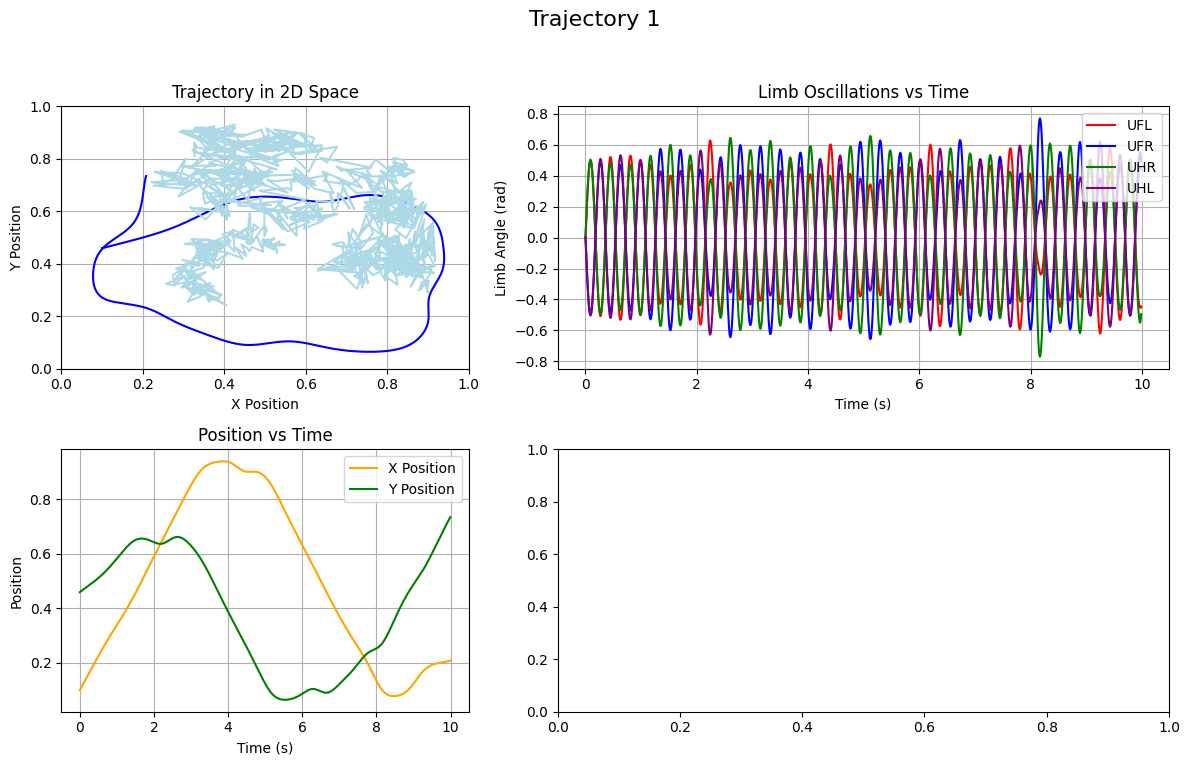

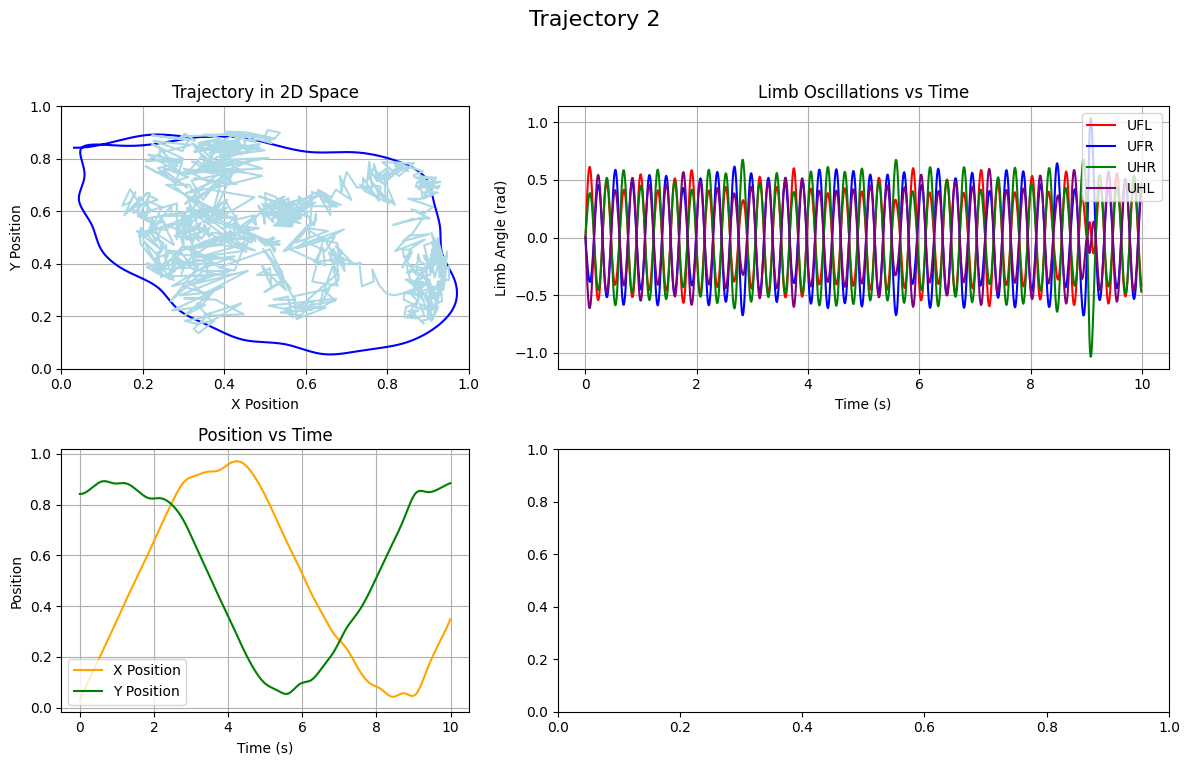

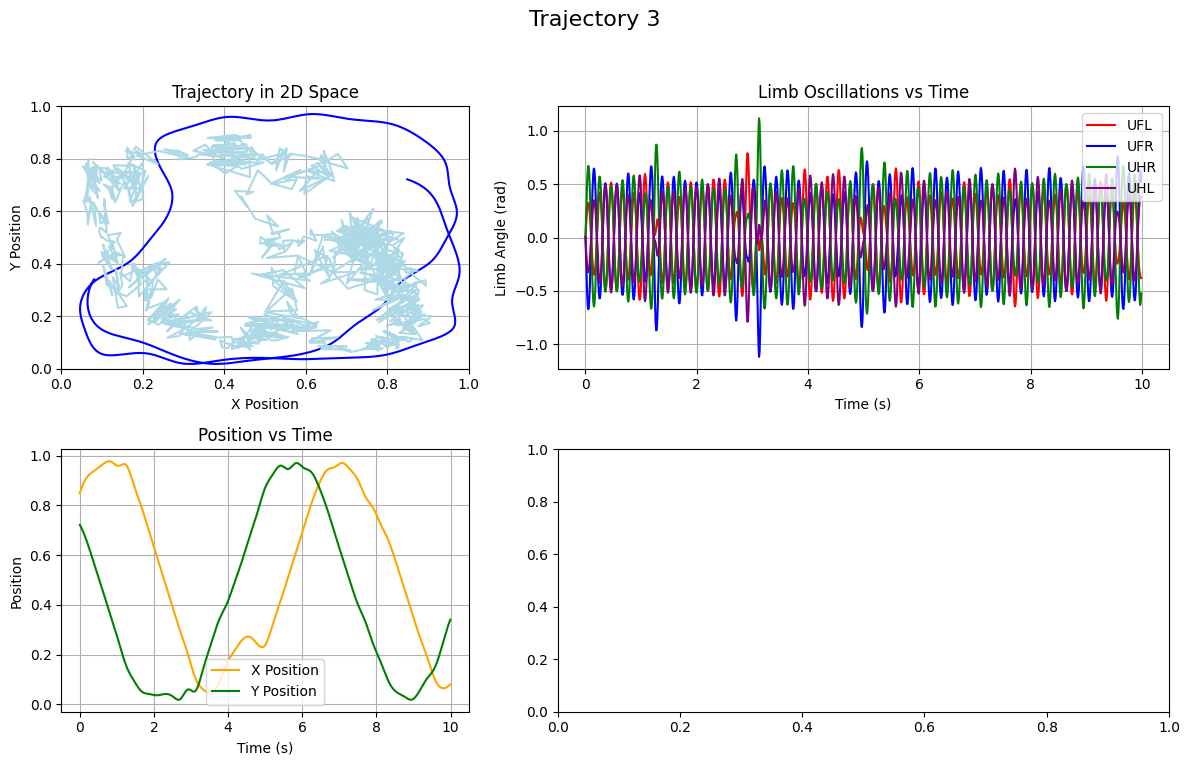

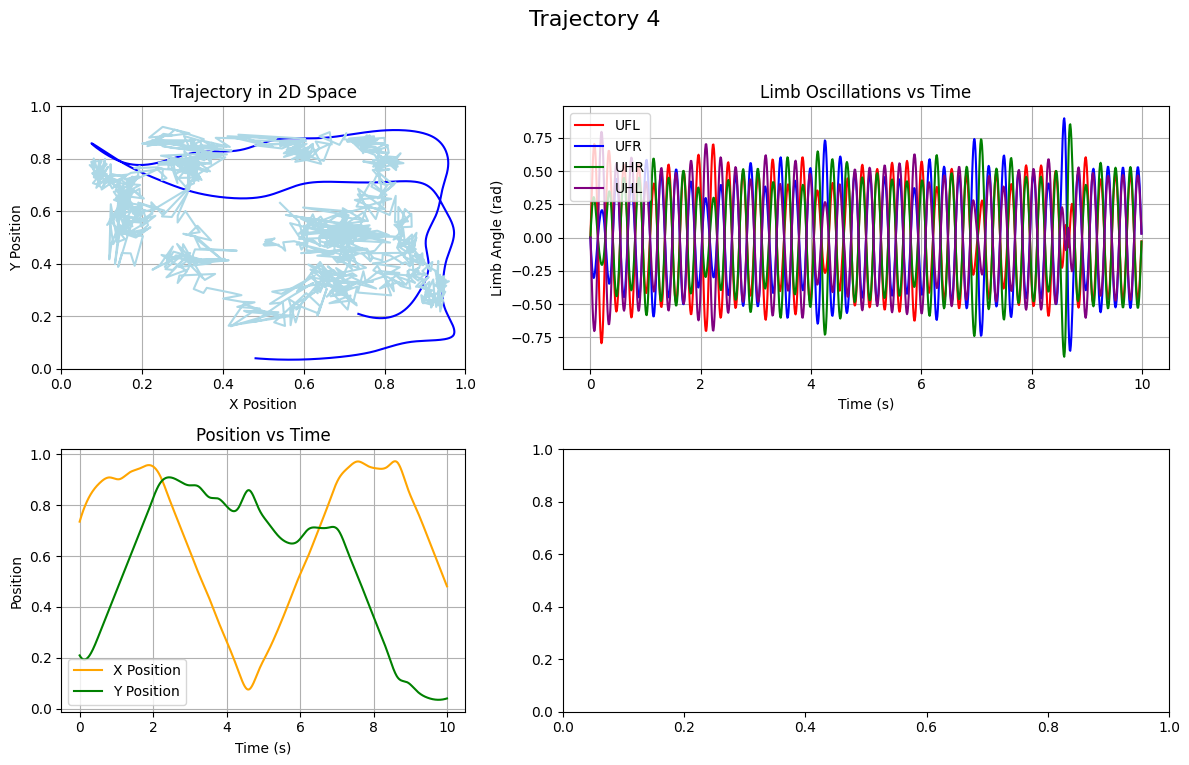

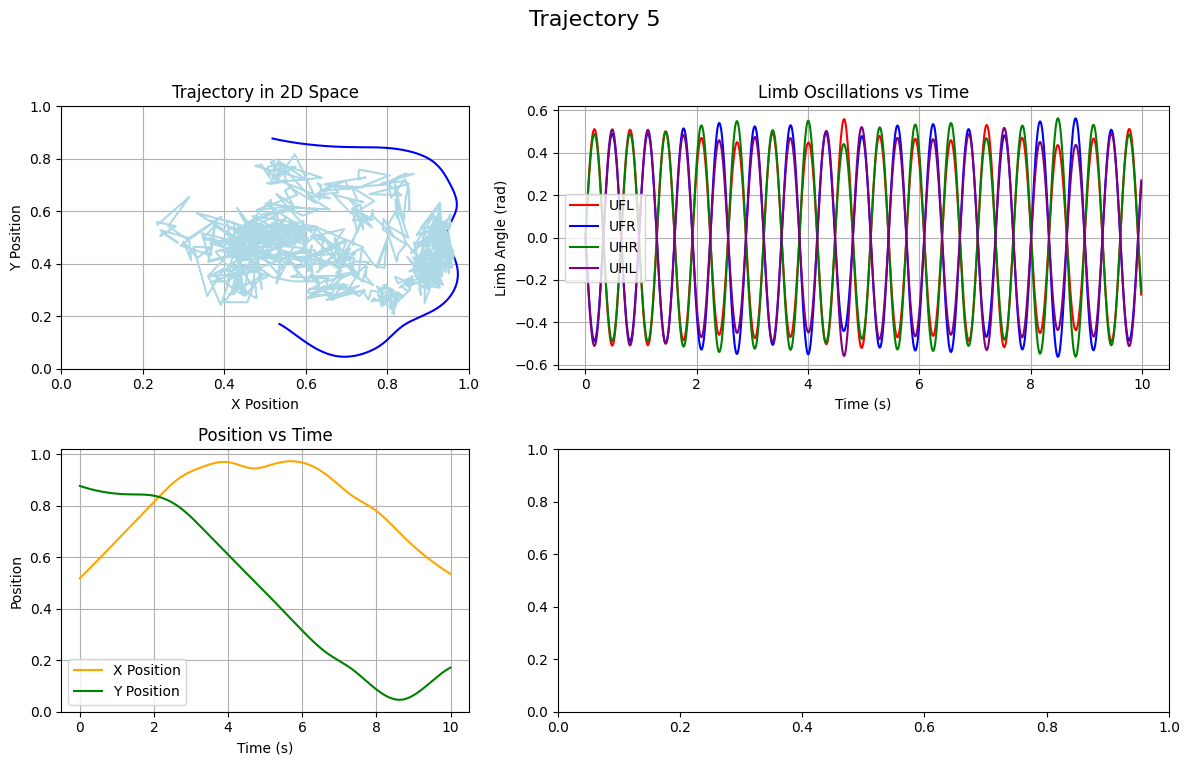

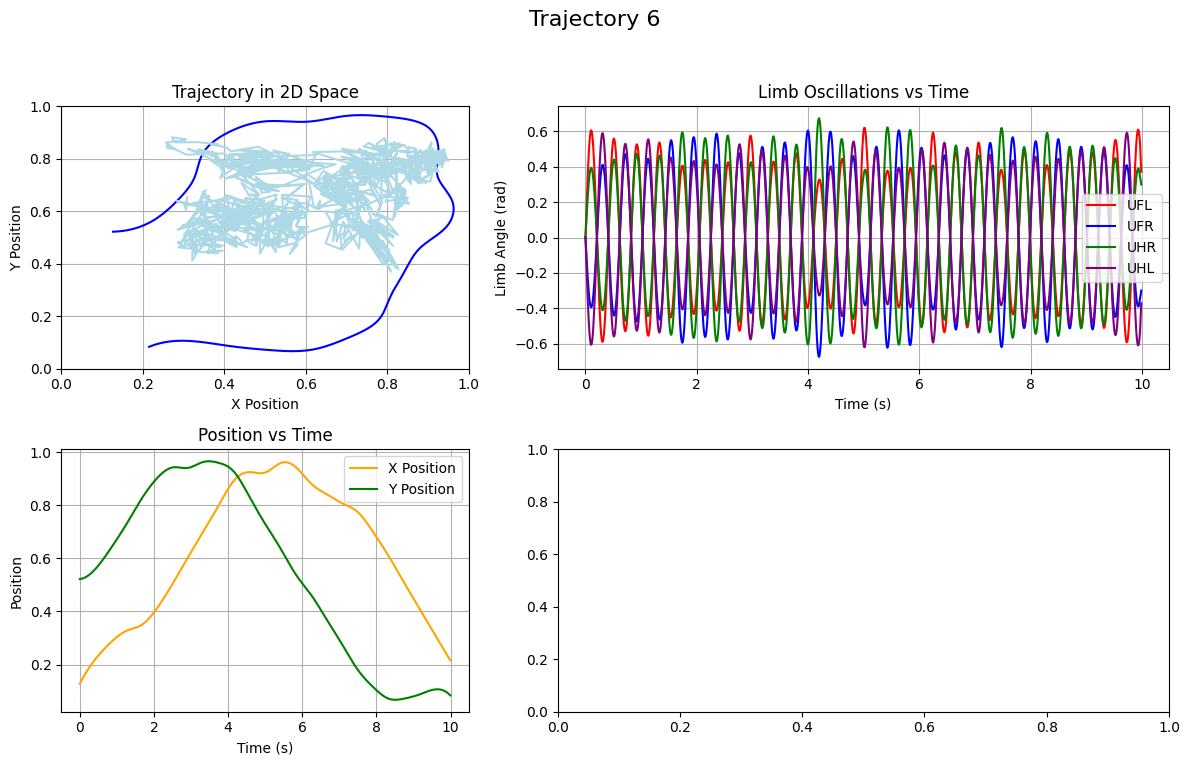

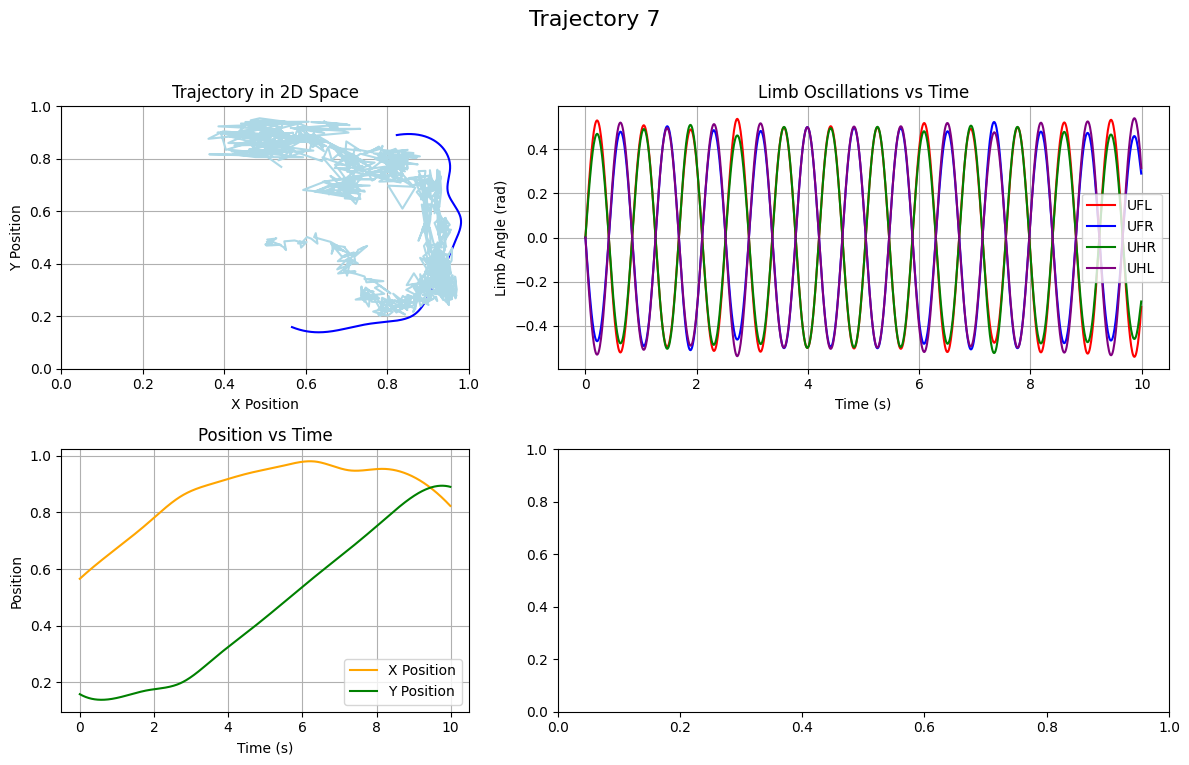

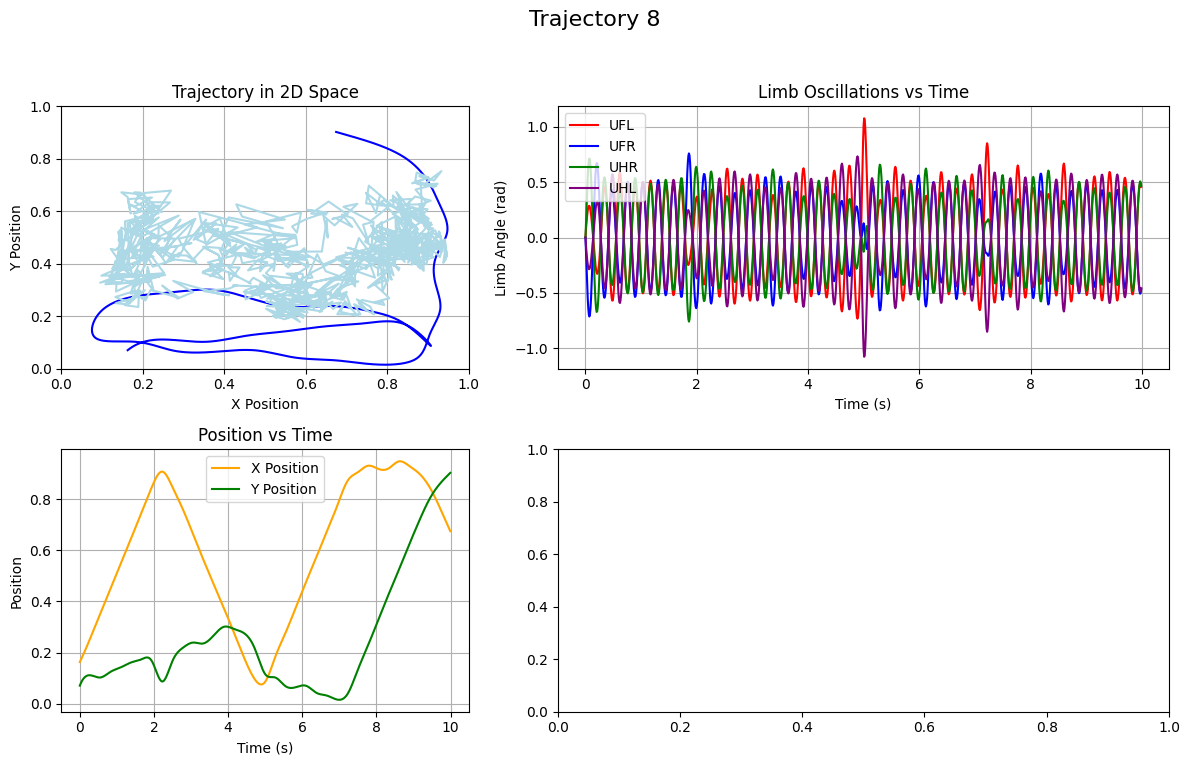

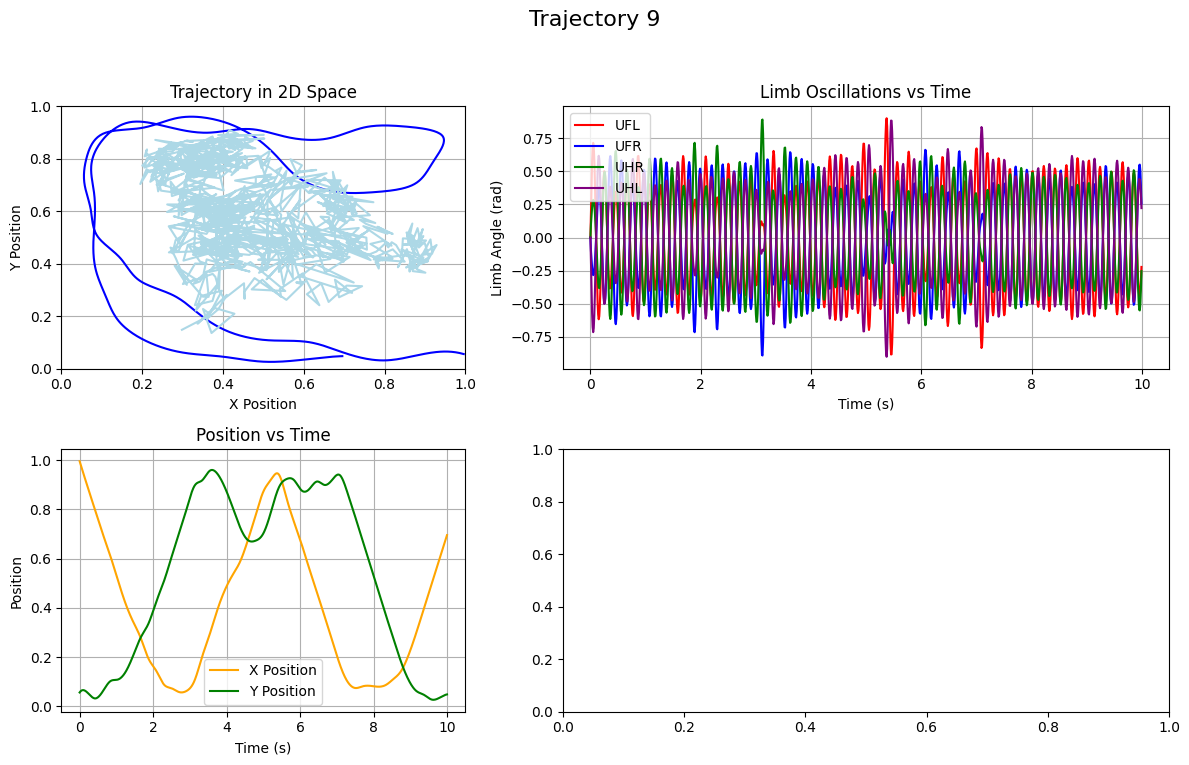

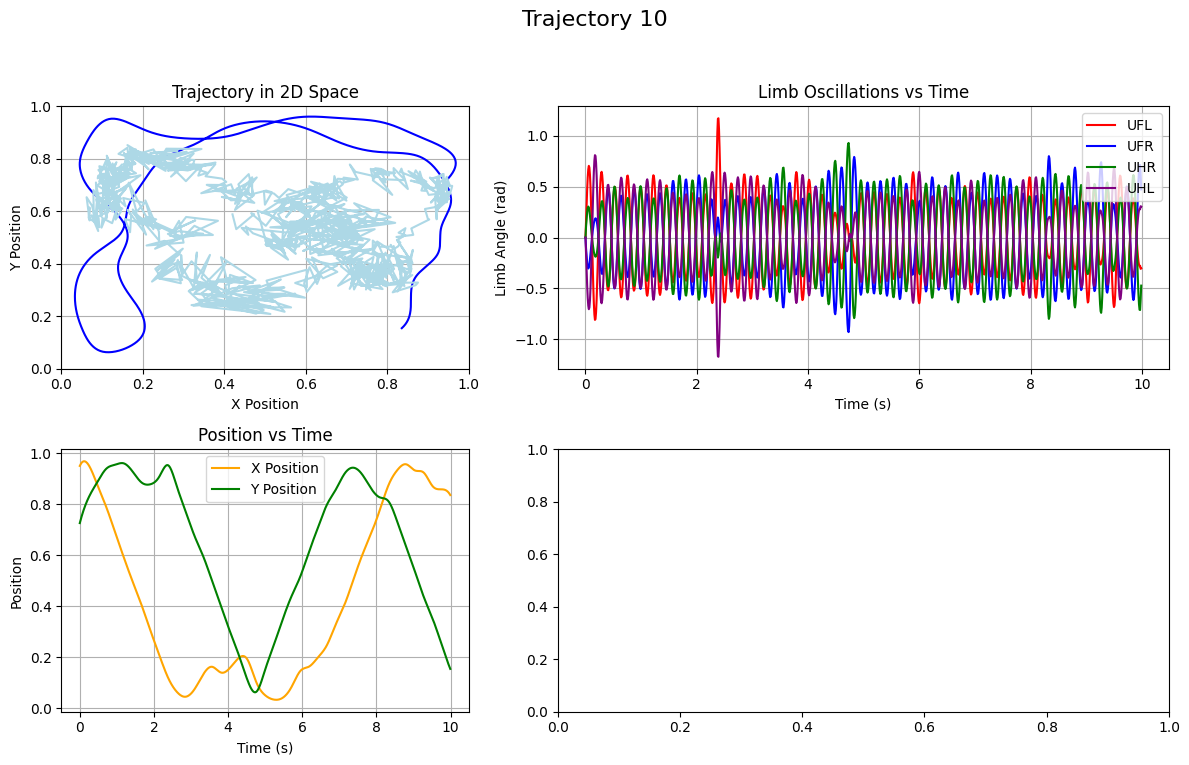

"\n    #Plotting k values\n    ax_bottom_right = axes[1, 1]\n\n    ax_bottom_right.plot(t, k[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)\n    ax_bottom_right.set_ylabel('Curvature (k)')\n    #ax_k.legend(loc='upper right')\n"

In [43]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(0, 10):

    #traj_index = np.random.randint(0, 100)
    traj_index = i
    traj_data = Y['pos'][traj_index]
    X_traj = traj_data[:, 0]
    Y_traj = traj_data[:, 1]
    UFL, UFR, UHR, UHL = X[traj_index, :, :4].T
    

    # Time vector
    t = time_series[:len(X_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(X_traj, Y_traj, color='blue')
    axes[0, 0].plot(pos_pred[traj_index, :, 0], pos_pred[traj_index, :, 1], color='lightblue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, X_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, Y_traj, label='Y Position', color='green')
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

'''
    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')
'''
    